In [2]:
import pandas as pd
import numpy as np
dirty_data_priora = pd.read_csv('C:\\Users\\Lo_Sci\\Desktop\\Py\\Prio\\Priora_List1.csv')
dirty_data_priora.head(5)

,дата,время,часы в пути,Unnamed: 3,минуты в пути,пробег,средний расход,температура,маршрут,топливо,...,прогревы,время на прогрев,топливо на прогрев,длина поездки.1,топливо поездки.1,расход поездки.1,час..1,Unnamed: 27,мин..1,средняя скорость.1
0,28.04.2016,21:49:00,NaN,NaN,NaN,22222,"10,5",6,98,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,03.05.2016,10:57:00,11.0,:,22.0,22368,"10,7",-1,"244,2","26,2",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,03.05.2016,11:45:00,12.0,:,0.0,22401,NaN,2,277,29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,03.05.2016,13:26:00,12.0,:,16.0,22402,10,-2,"278,9","29,2",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,03.05.2016,14:05:00,12.0,:,56.0,22438,10,1,"314,5","31,5",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# из онлайн-таблицы экспортировалось слишком много лишних столбцов. Отбираем нужные (которые были собраны из БК Приоры)
priora_only_input = dirty_data_priora[['дата', 'часы в пути', 'минуты в пути', 'пробег', 'средний расход', 
                                       'температура', 'маршрут', 'топливо', 'откуда', 'до куда']]
priora_only_input.head(5)

,дата,часы в пути,минуты в пути,пробег,средний расход,температура,маршрут,топливо,откуда,до куда
0,28.04.2016,NaN,NaN,22222,"10,5",6,98,NaN,NaN,NaN
1,03.05.2016,11.0,22.0,22368,"10,7",-1,"244,2","26,2",город,город
2,03.05.2016,12.0,0.0,22401,NaN,2,277,29,город,"Мана, сосна"
3,03.05.2016,12.0,16.0,22402,10,-2,"278,9","29,2","Мана, сосна","Мана, трасса"
4,03.05.2016,12.0,56.0,22438,10,1,"314,5","31,5","Мана, трасса",город


In [4]:
# обнаруживаем, что большинство данных импортировалось как текст
priora_only_input.dtypes

дата               object
часы в пути       float64
минуты в пути     float64
пробег             object
средний расход     object
температура        object
маршрут            object
топливо            object
откуда             object
до куда            object
dtype: object

In [5]:
# как текст импортировались те столбцы, в которых были числа с плавающей точкой
#    потому что в онлайн-таблице использовалась запятая -> заменяем ее на точку.
# переводим нужные нам данные в цифры (добавляем их как новые столбцы) и берем разность между сосоедними строчками
priora_num = priora_only_input.rename(columns={'часы в пути': 'hours', 'маршрут': 'km', 'минуты в пути':'minutes'})
priora_num['temperature'] = pd.to_numeric(priora_num['температура'].str.replace(',','.'), errors='coerce')
priora_num['path'] = pd.to_numeric(priora_num['km'].str.replace(',','.'), errors='coerce')
priora_num['hrs'] = priora_num.hours + priora_num.minutes/60
priora_num['fuel'] = pd.to_numeric(priora_num['топливо'].str.replace(',','.'), errors='coerce')
priora_num['time_h'] = np.diff(priora_num.hrs, prepend=0)
priora_num['benz'] = np.diff(priora_num.fuel, prepend=0)
priora_num['distance'] = np.diff(priora_num.path, prepend=0)
priora_num['av_speed'] = priora_num.distance / priora_num.time_h
priora_num['rashod'] = 100 * priora_num.benz / priora_num.distance

priora_num.drop(columns=['откуда', 'до куда']).head()

,дата,hours,minutes,пробег,средний расход,температура,km,топливо,temperature,path,hrs,fuel,time_h,benz,distance,av_speed,rashod
0,28.04.2016,NaN,NaN,22222,"10,5",6,98,NaN,6.0,98.0,NaN,NaN,NaN,NaN,98.0,NaN,NaN
1,03.05.2016,11.0,22.0,22368,"10,7",-1,"244,2","26,2",-1.0,244.2,11.366667,26.2,NaN,NaN,146.2,NaN,NaN
2,03.05.2016,12.0,0.0,22401,NaN,2,277,29,2.0,277.0,12.000000,29.0,0.633333,2.8,32.8,51.789474,8.536585
3,03.05.2016,12.0,16.0,22402,10,-2,"278,9","29,2",-2.0,278.9,12.266667,29.2,0.266667,0.2,1.9,7.125000,10.526316
4,03.05.2016,12.0,56.0,22438,10,1,"314,5","31,5",1.0,314.5,12.933333,31.5,0.666667,2.3,35.6,53.400000,6.460674


In [6]:
# отфильтровываем неразумные данные и исключаем нечисловые (вспомогательные информационные) колонки
priora_detailsfree = priora_num[['temperature', 'distance', 'time_h', 'benz', 'av_speed', 'rashod']] \
                                                    .query('distance > 0 & time_h > 0')

priora_detailsfree.head()

,temperature,distance,time_h,benz,av_speed,rashod
2,2.0,32.8,0.633333,2.8,51.789474,8.536585
3,-2.0,1.9,0.266667,0.2,7.125000,10.526316
4,1.0,35.6,0.666667,2.3,53.400000,6.460674
5,24.0,366.2,16.066667,37.2,22.792531,10.158383
6,24.0,5.3,0.083333,0.4,63.600000,7.547170


In [7]:
# высчитываем глобальные величины по всей базе
global_sr_ras = 100 * priora_detailsfree.benz.sum() / priora_detailsfree.distance.sum()
global_sr_skor = priora_detailsfree.distance.sum() / priora_detailsfree.time_h.sum()
print(
        'средняя скорось за все время эксплуатации = ', round(global_sr_skor, 2),
        'км/ч, при среднем расходе', round(global_sr_ras, 2), 'л/100км'
     )

средняя скорось за все время эксплуатации =  24.72 км/ч, при среднем расходе 9.83 л/100км


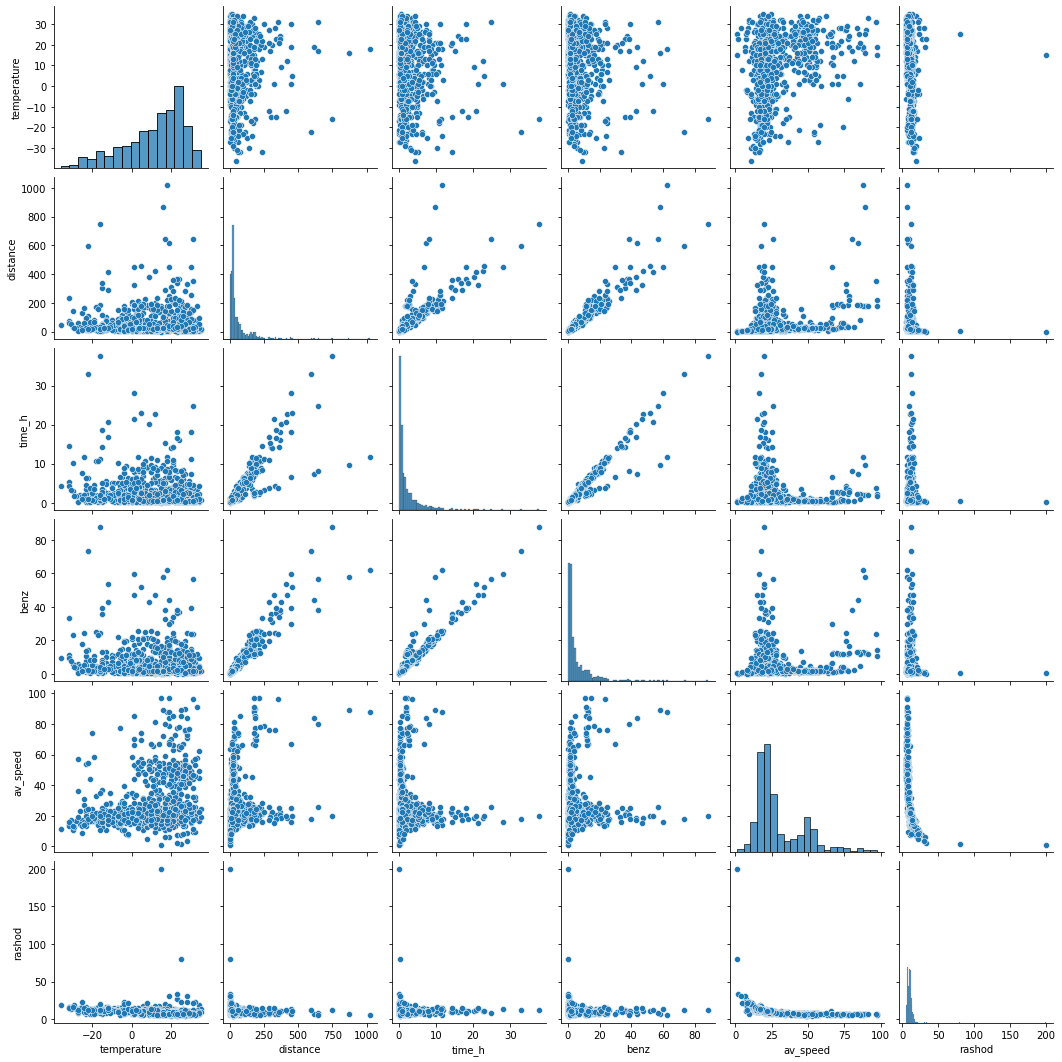

In [8]:
# разведка распределений и корреляций
import seaborn as sns
sns.pairplot(data=priora_detailsfree)

<AxesSubplot:xlabel='av_speed', ylabel='rashod'>

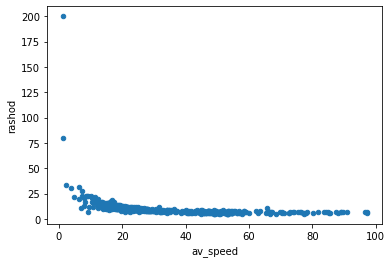

In [9]:
# обнаруживаем, что две точки сильно выбиваются
priora_detailsfree.plot.scatter(x='av_speed', y='rashod')

<AxesSubplot:xlabel='av_speed', ylabel='rashod'>

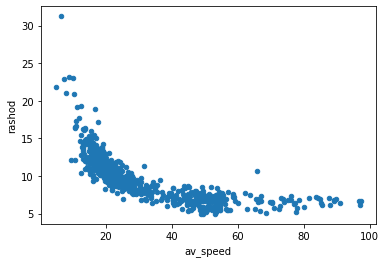

In [10]:
#поэтому отсеем их более жестким фильтром
priora_detailsfree = priora_num[['temperature', 'distance', 'time_h', 'benz', 'av_speed', 'rashod']] \
                    .query('distance > 3 & time_h > 0 & rashod < 50')
priora_detailsfree.plot.scatter(x='av_speed', y='rashod')

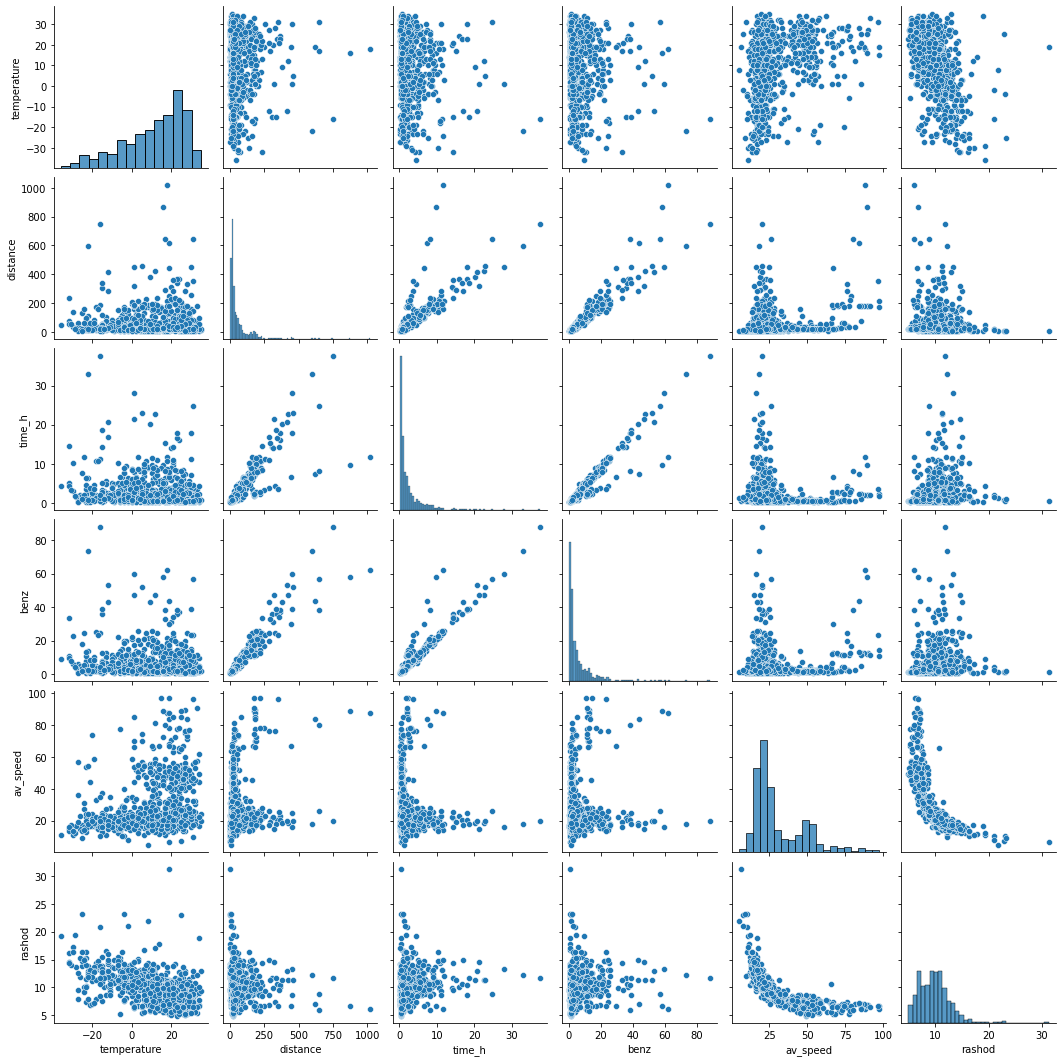

In [11]:
# разведка распределений и корреляций
import seaborn as sns
sns.pairplot(data=priora_detailsfree)

In [13]:
# можно увидеть, что расход наибольшим образм связан со скоростью и температурой
priora_detailsfree.corr()

,temperature,distance,time_h,benz,av_speed,rashod
temperature,1.000000,-0.013989,-0.156964,-0.124806,0.326785,-0.510098
distance,-0.013989,1.000000,0.831035,0.948421,0.131741,0.004061
time_h,-0.156964,0.831035,1.000000,0.956858,-0.223498,0.233743
benz,-0.124806,0.948421,0.956858,1.000000,-0.049410,0.151868
av_speed,0.326785,0.131741,-0.223498,-0.049410,1.000000,-0.739971
rashod,-0.510098,0.004061,0.233743,0.151868,-0.739971,1.000000


In [1]:
# также есть аномалии в зависимости, например, потраченного бензина от времени.
# Распределение средней скорости имеем две (или более) моды